In [219]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import cohen_kappa_score, roc_auc_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse
from xgboost import XGBClassifier
from sklearn.model_selection import GroupKFold

In [220]:
import pandas as pd
import numpy as np
df = pd.read_csv('ca1-dataset.csv')
df1= pd.read_csv('ca2-dataset.csv')

/var/folders/df/kmhwm37d4cx52kbwd321lk100000gn/T/ipykernel_65581/2884733941.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df1.corr()


<Axes: >

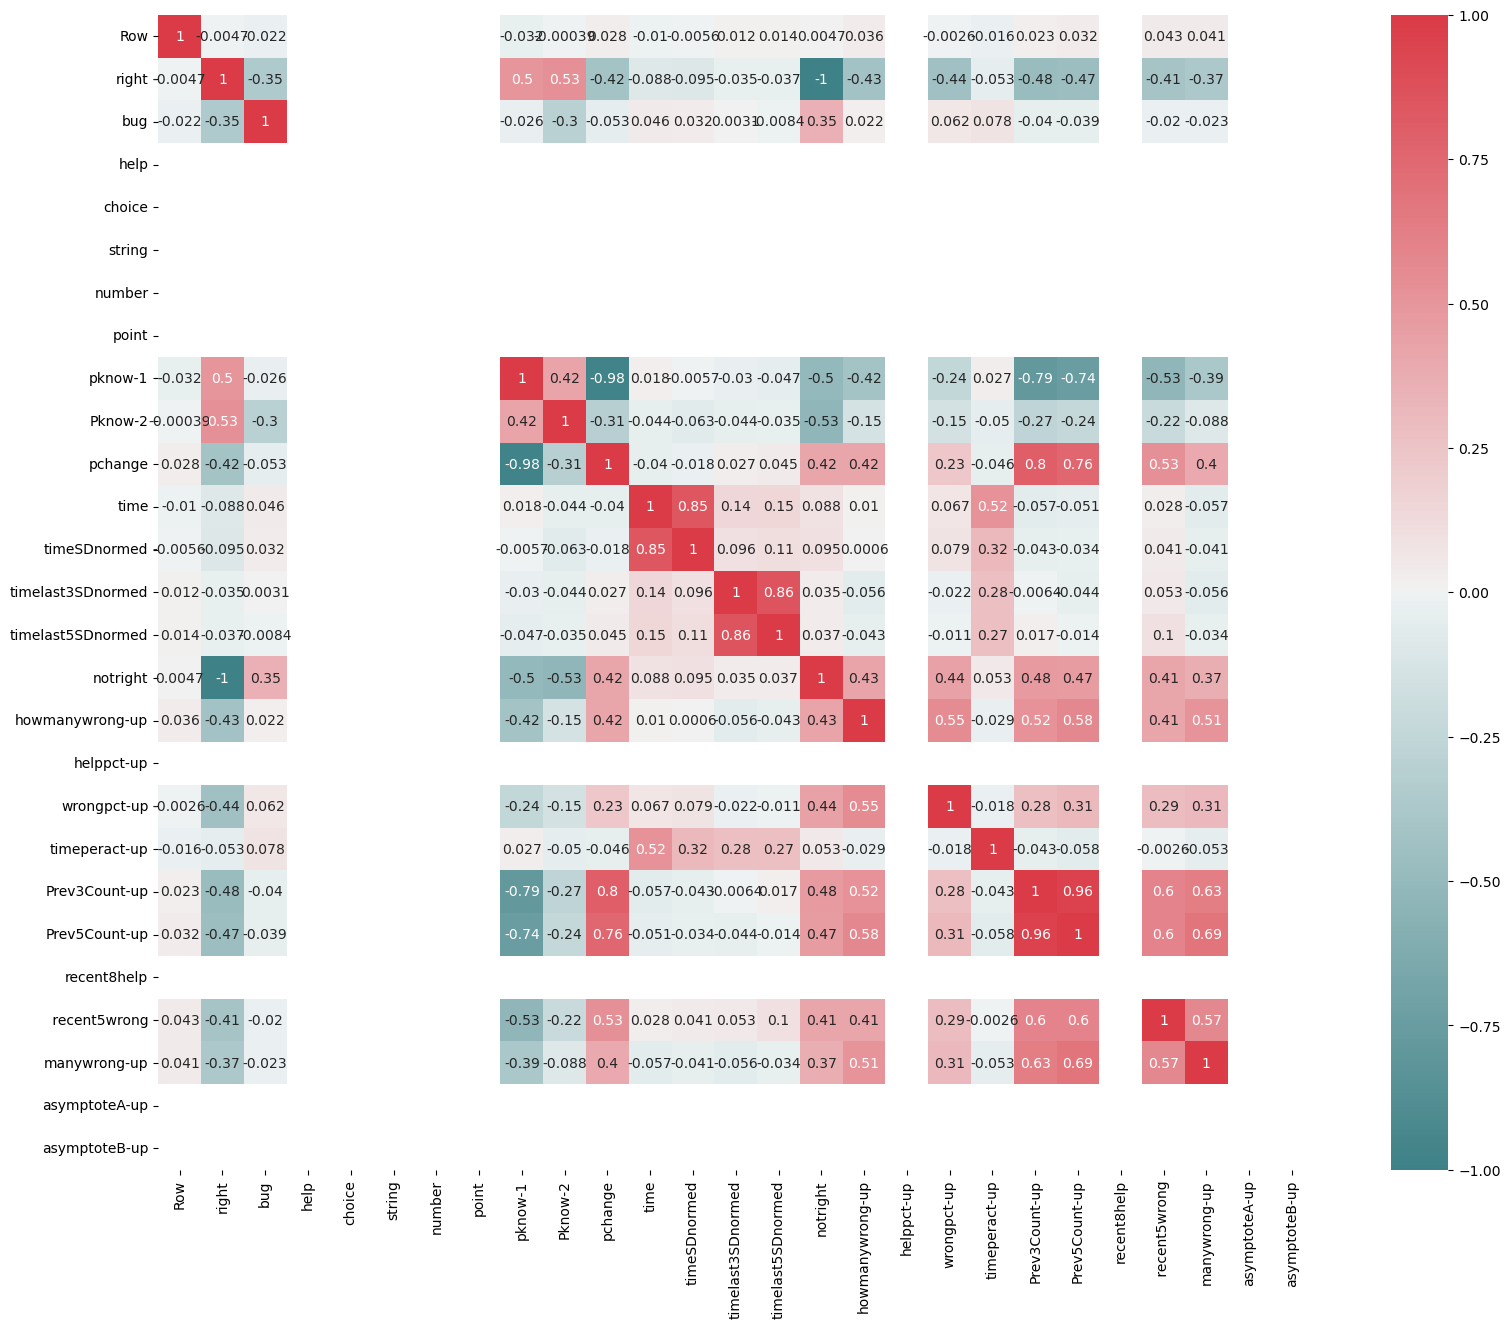

In [221]:
# Feature Engineering Brainstorming
# Find zero-variance features
f, ax = plt.subplots(figsize=(20, 15))

corr = df1.corr()

sns.heatmap(corr, mask=np.zeros_like(corr),
           cmap=sns.diverging_palette(200, 10, as_cmap=True), annot=True,
           square=True, ax=ax)

In [222]:
# Drop the data with only zero values
df1=df1.drop(columns=['Unique-id','namea','Coder', 'cell', 'prod', 'lesson', 'Row','asymptoteA-up', 'asymptoteB-up', 'help', 'choice', 'string', 'number', 'point','helppct-up','recent8help'])


In [223]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1745 entries, 0 to 1744
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   right              1745 non-null   int64  
 1   bug                1745 non-null   int64  
 2   pknow-1            1745 non-null   float64
 3   Pknow-2            1745 non-null   float64
 4   pchange            1745 non-null   int64  
 5   time               1745 non-null   int64  
 6   timeSDnormed       1745 non-null   float64
 7   timelast3SDnormed  1745 non-null   float64
 8   timelast5SDnormed  1745 non-null   float64
 9   notright           1745 non-null   int64  
 10  howmanywrong-up    1745 non-null   int64  
 11  wrongpct-up        1745 non-null   int64  
 12  timeperact-up      1745 non-null   float64
 13  Prev3Count-up      1745 non-null   int64  
 14  Prev5Count-up      1745 non-null   int64  
 15   recent5wrong      1745 non-null   int64  
 16  manywrong-up       1745 

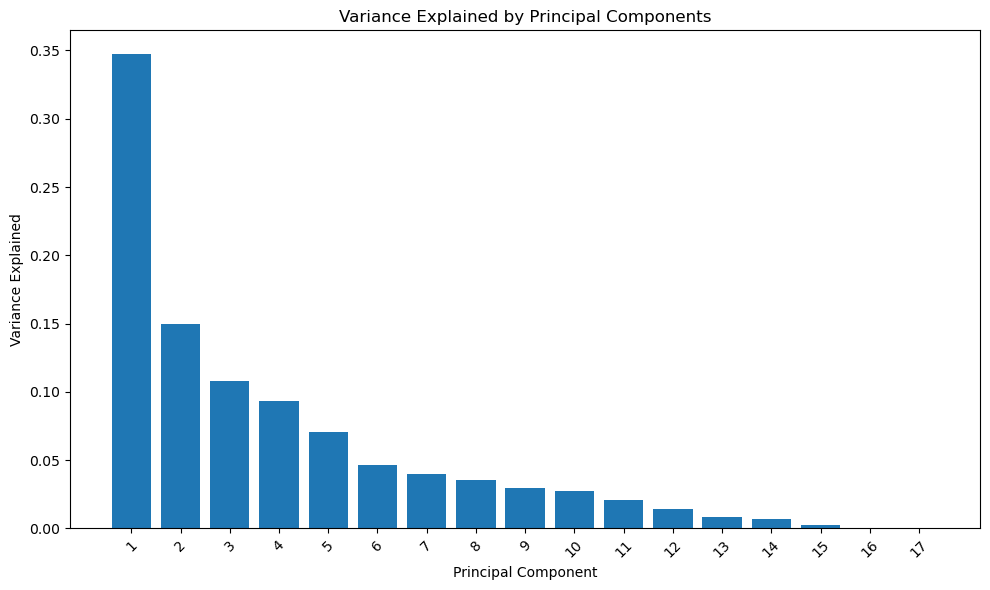

In [224]:
# Feature Engineering Brainstorming
# Apply PCA

predictors = df1.drop(columns=['Behaviour'])
scaler = StandardScaler()
predictors_std = scaler.fit_transform(predictors.select_dtypes(include=['float64', 'int64']))

pca = PCA()
principal_components = pca.fit_transform(predictors_std)

# Creating a bar chart
plt.figure(figsize=(10,6))
plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, tick_label=range(1, len(pca.explained_variance_ratio_)+1))
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Variance Explained by Principal Components')
plt.xticks(rotation=45)  
plt.tight_layout() 
plt.show()

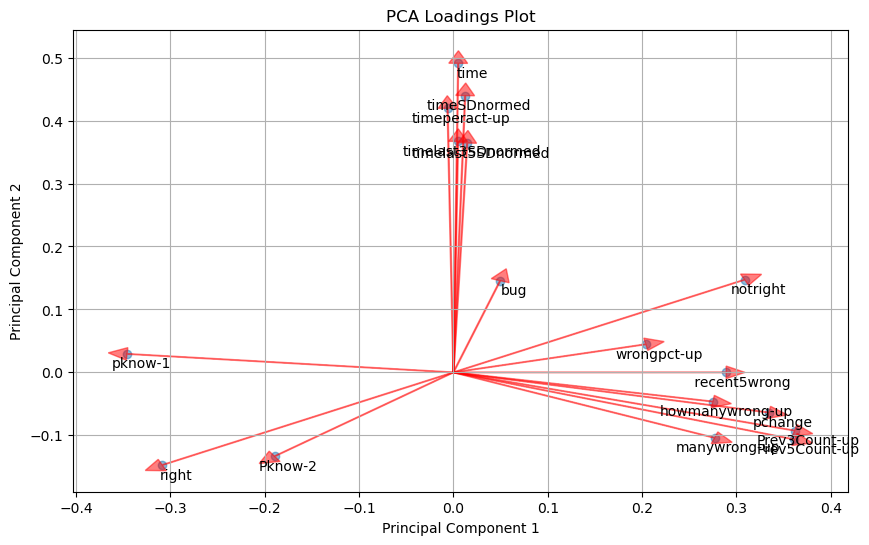

In [225]:
# Feature Engineering Brainstorming 
# Apply PCA for feature contribution and corrletion

predictors = df1.drop(columns=['Behaviour'])
scaler = StandardScaler()
predictors_std = scaler.fit_transform(predictors.select_dtypes(include=['float64', 'int64']))

pca = PCA(n_components=2) 
principal_components = pca.fit_transform(predictors_std)
loadings = pca.components_.T

# Creating a loadings plot
plt.figure(figsize=(10,6))
plt.scatter(loadings[:,0], loadings[:,1], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

for i, txt in enumerate(predictors.columns):
    plt.arrow(0, 0, loadings[i,0], loadings[i,1], color='r', alpha=0.5, head_width=0.02, head_length=0.02)
    plt.annotate(txt, (loadings[i,0], loadings[i,1]), textcoords="offset points", xytext=(10,-10), ha='center')

plt.title('PCA Loadings Plot')
plt.grid()
plt.show()

In [227]:
# Create 10 New Features

# History of knowledge estimate change: 'Pchange_so_far' & 'right_so_far'
df2['Pchange_so_far'] = df2.groupby('Unique-id')['pchange'].cumsum()
df2['right_so_far'] = df2.groupby('Unique-id')['notright'].cumsum()

# Capturing learning moment: 'pknow-1_right' & 'Pknow-2_right'
df2['pknow-1_right'] = df2['pknow-1'] * df2['right']
df2['Pknow-2_right'] = df2['Pknow-2'] * df2['right']

# Percentages of wrong action type: 'pct_wrong'
df2['pct_wrong'] = df2['wrongpct-up'] / (df2['howmanywrong-up'] + 0.01) # Avoid division by zero

# Time taken for wrong action: 'tsd_wrong'
df2['tsd_wrong'] = df2['wrongpct-up'] * df2['timeSDnormed']

# Total counts per last-n-actions: 'conuts-prev3' and 'counts-prev5'
df2['conuts-prev3'] = df2.groupby('Unique-id')['Prev3Count-up'].transform('sum')
df2['conuts-prev5'] = df2.groupby('Unique-id')['Prev5Count-up'].transform('sum')
                                                 
# Time taken for last-n-actions: 'tsd_prev3' & 'tsd_prev5'                                            
df2['tsd_prev3'] = df2['Prev3Count-up'] * df2['timelast3SDnormed'] 
df2['tsd_prev5'] = df2['Prev5Count-up'] * df2['timelast5SDnormed']    

df2[['Pchange_so_far', 'right_so_far', 'pknow-1_right', 'Pknow-2_right', 'pct_wrong', 'tsd_wrong',
     'conuts-prev3', 'conuts-prev5', 'tsd_prev3', 'tsd_prev5']].head()


,Pchange_so_far,right_so_far,pknow-1_right,Pknow-2_right,pct_wrong,tsd_wrong,conuts-prev3,conuts-prev5,tsd_prev3,tsd_prev5
0,0,0,0.888287,0.888287,0.000000,0.000000,0,0,0.0,0.0
1,0,0,0.888287,0.888287,0.000000,-0.000000,0,0,-0.0,0.0
2,0,0,0.888287,0.888287,0.000000,0.000000,0,0,-0.0,-0.0
3,0,1,0.000000,0.000000,0.990099,-0.257788,0,0,-0.0,-0.0
4,0,0,0.988464,0.988464,0.000000,-0.000000,0,0,-0.0,-0.0


In [234]:
# Merge datasets 
# Check dataframe mismatch in the number of rows
df2_1 = df2.groupby('Unique-id').last().reset_index()
df3 = pd.merge(df, df2_1, on = 'Unique-id', how = 'inner')
df3.to_csv('new_data.csv', index=False)
new_df = pd.read_csv('new_data.csv')
le = LabelEncoder()
new_df['Behaviour'] = le.fit_transform(new_df['Behaviour'])


In [235]:
# New dataset - Model Goodness


X = new_df.drop(columns=['OffTask','Unique-id','namea'],axis=1)

y = new_df['OffTask'].map({'Y':1,'N':0})

group_dict = {}
groups = np.array([])

for index, row in df.iterrows():
    student_id = row['namea']
    if student_id not in group_dict:
        group_dict[student_id] = index
    groups = np.append(groups, group_dict[student_id])
    
gkf = GroupKFold(n_splits=10)

kappa_values = list()
f1_values = list()
roc_auc_values = list()

for train_index, test_index in gkf.split(X, y, groups):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y[train_index]
    y_test = y[test_index]  

    xgb = XGBClassifier()
    xgb = XGBClassifier(learning_rate=0.5, n_estimators=200, random_state=5)
    xgb.fit(X_train, y_train.ravel())
    predictions = xgb.predict(X_test)
    
    kappa = cohen_kappa_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, predictions)

    kappa_values.append(kappa)
    f1_values.append(f1)
    roc_auc_values.append(roc)
    
    mean_kappa = np.mean(kappa_values)
    mean_f1 = np.mean(f1_values)
    mean_roc_auc = np.mean(roc_auc_values)
    
print(f"Mean Cohen's Kappa: {mean_kappa:.2f}")
print(f"F1-Score: {mean_f1:.2f}")
print(f"ROC AUC: {mean_roc_auc:.2f}")

Mean Cohen's Kappa: 0.95
F1-Score: 0.96
ROC AUC: 0.75


In [230]:
# Old dataset(df) - Model Goodness
df = pd.read_csv('ca1-dataset.csv')
X = df.drop(columns=['OffTask','Unique-id','namea'],axis=1)
y = df['OffTask'].map({'Y':1,'N':0})


group_dict = {}
groups = np.array([])

for index, row in df.iterrows():
    student_id = row['namea']
    if student_id not in group_dict:
        group_dict[student_id] = index
    groups = np.append(groups, group_dict[student_id])
    
gkf = GroupKFold(n_splits=10)

kappa_values = list()
f1_values = list()
roc_auc_values = list()

for train_index, test_index in gkf.split(X, y, groups):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y[train_index]
    y_test = y[test_index]  

    xgb = XGBClassifier()
    xgb = XGBClassifier(learning_rate=0.5, n_estimators=200, random_state=5)
    xgb.fit(X_train, y_train)
    predictions = xgb.predict(X_test)
    
    kappa = cohen_kappa_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, predictions)

    kappa_values.append(kappa)
    f1_values.append(f1)
    roc_auc_values.append(roc)
    
    mean_kappa = np.mean(kappa_values)
    mean_f1 = np.mean(f1_values)
    mean_roc_auc = np.mean(roc_auc_values)
    
print(f"Mean Cohen's Kappa: {mean_kappa:.2f}")
print(f"F1-Score: {mean_f1:.2f}")
print(f"ROC AUC: {mean_roc_auc:.2f}")

Mean Cohen's Kappa: 0.31
F1-Score: 0.32
ROC AUC: 0.75
